In [12]:
import os
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
import numpy as np
import pandas as pd
import sys
sys.path.append(r'/home/jmwang/WorkSpace/GENiPPI/')
from gPPMol.nets import EncoderCNN, DecoderRNN, GNN_Model

In [13]:
from gPPMol.utils import *
from tqdm import tqdm
import argparse
import multiprocessing
from gPPMol.ppi_processing.collate_fn import collate_fn
from gPPMol.ppi_processing.Prepare_Input import Prepare_Input
from gPPMol.ppi_processing.Single_Dataset import Single_Dataset
from torch.utils.data import DataLoader

from gPPMol.models_3d.wgan_clipping import WGAN_CP
from gPPMol.models_3d.wgan_gradient_penalty import WGAN_GP

In [14]:
batch_size = 8
savedir = "model"
os.makedirs(savedir, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(device)
is_cuda = True if device == "cuda" else False

structure_path="./interface.pdb"
input_file=Prepare_Input(structure_path)
list_npz = [input_file]
dataset = Single_Dataset(list_npz)
dataloader = DataLoader(dataset, 1, shuffle=False,
                            num_workers=1,
                            drop_last=False, collate_fn=collate_fn)
for batch_idx, sample in enumerate(dataloader):
    H, A1, A2, V, Atom_count = sample
    break

smiles = np.load("./gPPMol/example.npy") #(305584, 242)   105
y = np.load("./gPPMol/example_y.npy") #(305584,)

from gPPMol.comgen import decode_smiles
from gPPMol.gene import queue_datagen

multiproc = multiprocessing.Pool(1)
my_gen = queue_datagen(smiles, y, batch_size=batch_size, mp_pool=multiproc)
test_loader  = my_gen

from gPPMol.comgen import decode_smiles

cpu
Extracting 869/869 atoms for receptor, 49/49 atoms for ligand
After filtering the interface region, 42/101 residue in receptor, 6/6 residue in ligand
After filtering the interface region, 358 receptor, 44 ligand
./interface.rinterface ./interface.linterface
[[ 8.159  6.912  7.356]
 [ 9.189  6.856  8.389]
 [10.393  7.751  8.071]
 ...
 [17.357 12.334 21.525]
 [15.41  13.839 22.016]
 [14.595 14.703 21.636]] (402, 3) [34.82  25.324 32.67 ] [ 7.535 -1.647  0.633] [13.6425 13.4855 16.0185] [27.285 26.971 32.037] HEADER    CORNERS OF BOX
REMARK    CENTER (X Y Z)  13.642   13.486  16.018
REMARK    DIMENSIONS (X Y Z)   27.285  26.971  32.037 
ATOM      1  DUA BOX     1       7.535  -1.647   0.633
ATOM      2  DUB BOX     1       34.82  -1.647   0.633
ATOM      3  DUC BOX     1       34.82  -1.647   32.67
ATOM      4  DUD BOX     1       7.535  -1.647   32.67
ATOM      5  DUE BOX     1       7.535  25.324   0.633
ATOM      6  DUF BOX     1       34.82  25.324   0.633
ATOM      7  DUG BOX    

In [15]:
# Define the networks
params={}
params['n_graph_layer'] =4  #图卷积的层数
params['d_graph_layer'] =140  #图卷积每一层有多少个节点
params['n_FC_layer'] =4    #全连接层数
params['d_FC_layer'] =128    #全连接层每一层多少个节点
params['dropout_rate'] =0.3
params['initial_mu'] =0.0
params['initial_dev'] =1.0
params['N_atom_features'] = 28     #每个原子有28个特征值  不可修改
params['final_dimension'] = 4* 4* 4    #将 interface feature map to a 128 size of vector  can be changed
gnn_interface_model = GNN_Model(params)

encoder = EncoderCNN(9)
decoder = DecoderRNN(512, 1024, 37, 1)

gnn_interface_model.to(device)
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(37, 512)
  (lstm): LSTM(512, 1024, batch_first=True)
  (linear): Linear(in_features=1024, out_features=37, bias=True)
)

In [16]:
model_name = 'WGAN-CP'
channels = 9
generator_iters = 50000
batch_size = 8

if model_name == 'WGAN-CP':
    model = WGAN_CP(channels,is_cuda,generator_iters,gnn_interface_model,encoder,decoder,device,batch_size=8)
elif model_name == 'WGAN-GP':
    model = WGAN_GP(channels,is_cuda,generator_iters,gnn_interface_model,encoder,decoder,device,batch_size=8)        
else:
    print("Model type non-existing. Try again.")
    exit(-1)

WGAN_CP init model.


In [17]:
load_D = './discriminator.pkl'
load_G = './generator.pkl'

In [18]:
# Start model generating
captions1,captions2 = model.evaluate( test_loader,load_D, load_G,H, A1, A2, V, Atom_count)
smi = decode_smiles(captions1,captions2)

from rdkit import Chem

def filter_unique_canonical(in_mols):
    """
    :param in_mols - list of SMILES strings
    :return: list of uinique and valid SMILES strings in canonical form.
    """
    xresults = [Chem.MolFromSmiles(x) for x in in_mols]  # Convert to RDKit Molecule
    xresults = [Chem.MolToSmiles(x) for x in xresults if x is not None]  # Filter out invalids
    return [x for x in set(xresults)]  # Check for duplicates and filter out invalids

smi=filter_unique_canonical(smi)

print(smi,len(smi))

['O=C(Cc1ccccc1)Nc1ccc2oc(Cc3ccccc3)nc2c1', 'NC1CN(c2ccnc3cc(-c4ccncc4)cnc23)CCN1Cc1ccncc1', 'COc1cc(C=C2SC(=S)NC2=O)ccc1OCCCn1cnc2ccc(C)nc2c1=O', 'Clc1cc(Br)ccc1Cn1cnnc1-c1cccc(Cl)c1Cl', 'N=C(N)c1ccc(-c2ccc(C(=O)Nc3nccs3)cc2)cc1', 'CC(C)(C)c1ccc(C(=C(C(=O)[O-])c2ccc3c(c2)OCO3)c2ccno2)cc1', 'CN1CC(C(c2ccccc2)c2ccccc2)=NC1c1ccc(Cl)cc1', 'CN1CCN(CCCCNC(=O)c2ccc(N3CCC(N4CCCCC4)CC3)cc2)CC1', 'COc1cc(-n2c3c(c4ncnc(N)c42)CC3)ccc1NC(=O)C(C)(C)c1cccc(O)c1', 'CC1(O)C(O)C(COP2(=O)OCCC(c3cccnc3)O2)OC1n1cnc2nc(N)ccc21', 'Cn1ccnc1[S+]([O-])c1ccccc1-c1ccc(C(NC(=O)CCc2ccccc2)C(=O)O)cc1'] 11


RDKit ERROR: [14:30:37] SMILES Parse Error: unclosed ring for input: 'NCCC(=O)Nc1cccc(-c2cncc(Nc3ccc(N4CCn5cncn4)c3)c2)c1'
RDKit ERROR: [14:30:37] Can't kekulize mol.  Unkekulized atoms: 29
RDKit ERROR: 
RDKit ERROR: [14:30:37] Can't kekulize mol.  Unkekulized atoms: 5 10 18
RDKit ERROR: 
RDKit ERROR: [14:30:37] Can't kekulize mol.  Unkekulized atoms: 9 10 11 28 32
RDKit ERROR: 
RDKit ERROR: [14:30:37] Can't kekulize mol.  Unkekulized atoms: 15 16 18 19 20
RDKit ERROR: 


2019.03.4


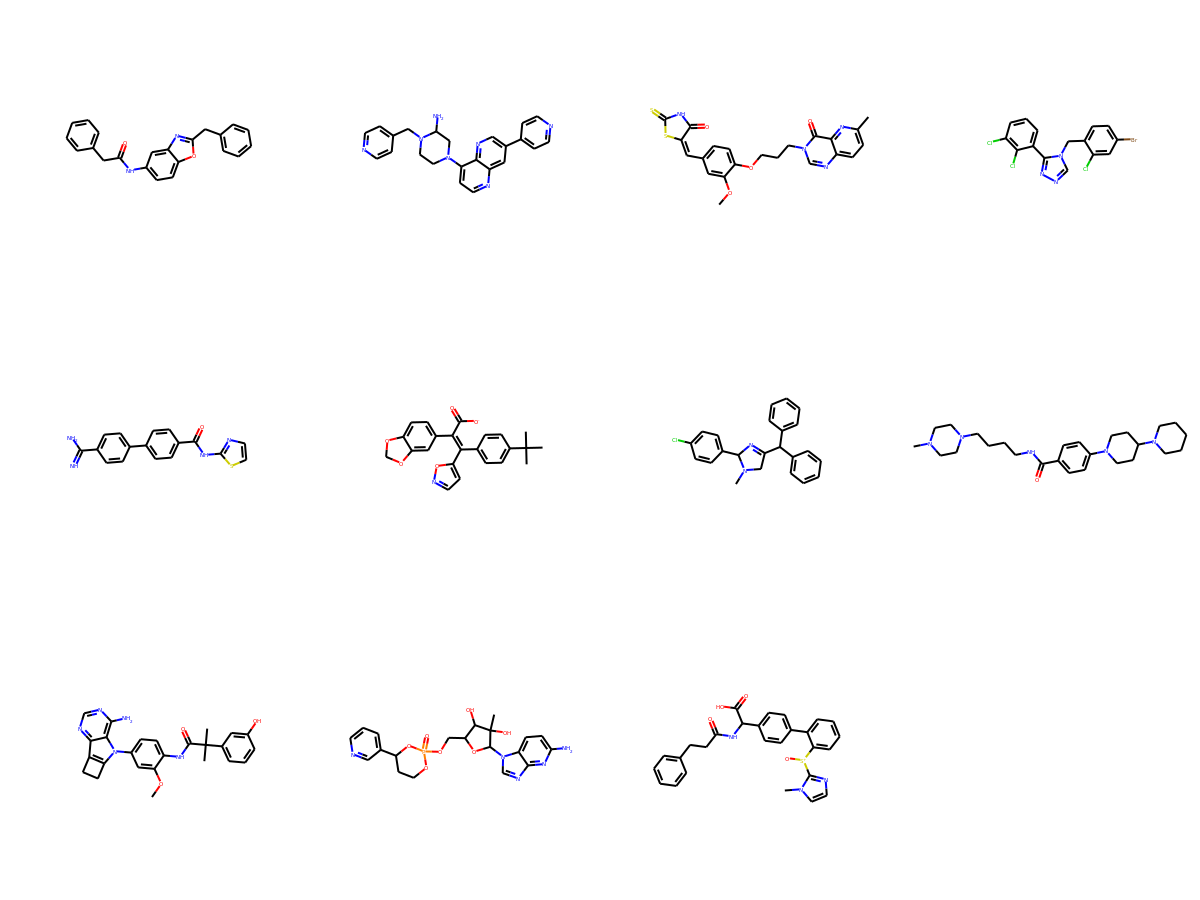

In [19]:
%matplotlib inline
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
print(rdBase.rdkitVersion)
genmols = [Chem.MolFromSmiles(x) for x in smi]
Chem.Draw.MolsToGridImage(genmols, molsPerRow=4, subImgSize=(300, 300))   #maxMols=200